In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{ (\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2} \frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [5]:
def simulate_jump(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y = 1.1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [6]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξa = 0.01
ξw = 100_000
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=2_000)

episode: 2000,	 ode error: 0.00011969687458604494,	 ft error: 2.086986406935054e-05
episode: 761,	 ode error: 0.0004207694314906779,	 ft error: 9.807217038471094e-09
episode: 816,	 ode error: 0.002007422635281751,	 ft error: 9.864251637736743e-09
episode: 2000,	 ode error: 0.0015424591448702958,	 ft error: 5.498163917605492e-05


In [8]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

(0.0, 6.393077023451692)

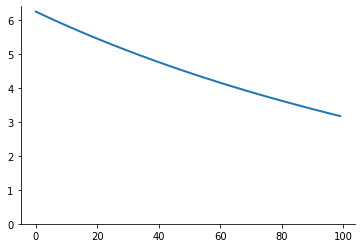

In [9]:
plt.plot(et)
plt.ylim(0)

In [9]:
πᶜt.shape

(100, 144)

(array([0.09103805, 0.10783686, 0.1727458 , 0.2805518 , 0.38505807,
        0.54512741, 0.40022175, 0.81464664, 1.33271266, 0.65695445,
        0.9767932 , 0.63177841, 0.53339088, 0.70742067, 0.7255333 ]),
 array([1.0154    , 1.13499133, 1.25458267, 1.374174  , 1.49376533,
        1.61335667, 1.732948  , 1.85253933, 1.97213067, 2.091722  ,
        2.21131333, 2.33090467, 2.450496  , 2.57008733, 2.68967867,
        2.80927   ]),
 <BarContainer object of 15 artists>)

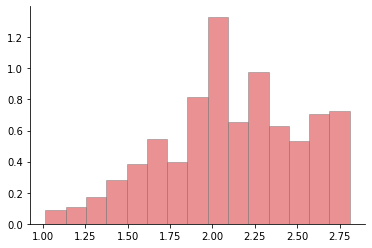

In [10]:
plt.hist(θ_list*1000, weights=πᶜt[-1], density=True, color='tab:red', bins=15, histtype='bar', ec='gray', alpha=.5,)

(0.0, 103.95)

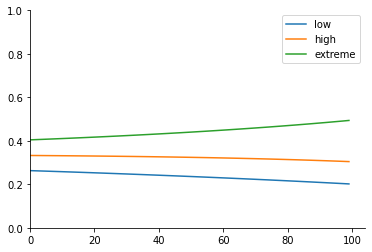

In [11]:
plt.plot(πᵈt[:,0], label="low")
plt.plot(πᵈt[:,1], label="high")
plt.plot(πᵈt[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(left=0)

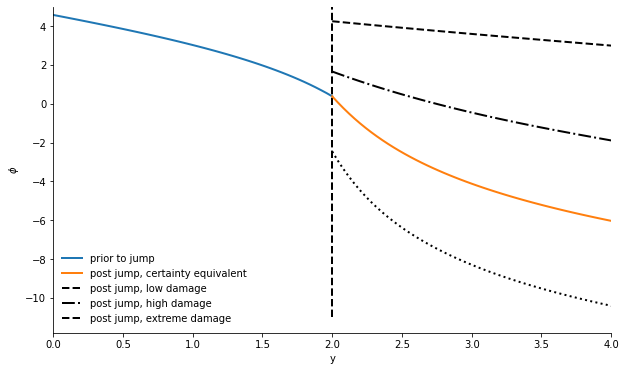

In [24]:
plt.figure(figsize = (10,6))
ϕ = solu['φ']
ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξp*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
plt.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
plt.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
plt.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
plt.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black", label="post jump, extreme damage")
# plt..xlim(0,4)
plt.ylim( top=5)
plt.ylabel('$\phi$')
plt.xlabel('y')
plt.xlim(left=0, right=4)
plt.legend()
# plt.savefig('value_matching.png', dpi=300)

In [12]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0.)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    ax3.set_ylim( top=5)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0, right=4)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

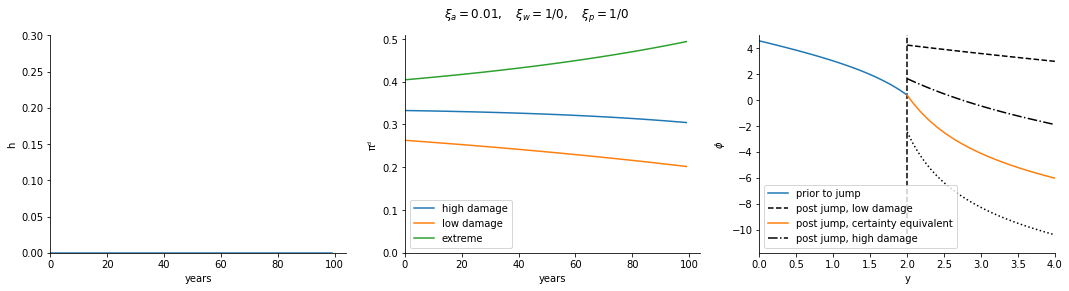

In [13]:
args_plot = (ξa, ξw, ξp, numy_bar)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

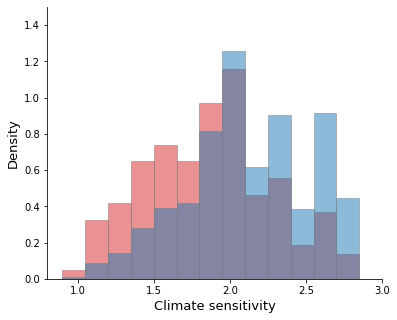

In [20]:
# histogram 10, 50, 90
fig,ax = plt.subplots(1, 1,figsize=(6,5))
bins = np.linspace(0, 3, 21)

ax.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax.set_xlabel('Climate sensitivity', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
# ax.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax.set_xticks(np.arange(0,3+0.5, 0.5))
ax.set_xlim(.8, 3)
plt.ylim(0,1.5)
# plt.savefig('../figures/new/climate_worstcase.pdf')
plt.show()

In [81]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξa = 1000*100
ξw = 5.
ξp = 5.
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 4849,	 ode error: 7.645539943590407e-05,	 ft error: 9.996326729340884e-09
episode: 5038,	 ode error: 0.0005953937062770712,	 ft error: 9.998885423338304e-09
episode: 5383,	 ode error: 0.0019846537347066612,	 ft error: 9.997140892892276e-09
episode: 1699,	 ode error: 0.0015283746876229784,	 ft error: 9.897232663054941e-09


(0.0, 1.0)

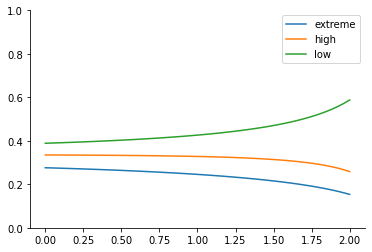

In [84]:
plt.plot(y_grid[:numy_bar+1], solu["πd"][0], label="extreme")
plt.plot(y_grid[:numy_bar+1], solu["πd"][1], label="high")
plt.plot(y_grid[:numy_bar+1], solu["πd"][2], label="low")
plt.legend()
plt.ylim(0,1)

Text(0, 0.5, 'Drift distortion')

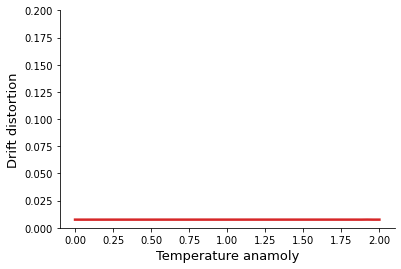

In [85]:
plt.plot(y_grid[:numy_bar+1], solu["h"], linewidth=2.5, color="tab:red")
plt.ylim(0, 0.2)
plt.xlabel("Temperature anamoly", fontsize=13)
plt.ylabel("Drift distortion", fontsize=13)
# plt.savefig('./paper_plots/drift_distortion.pdf')

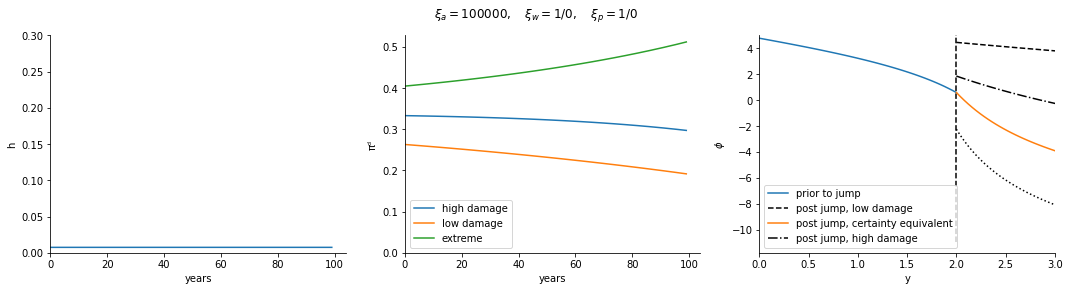

In [86]:
args_plot = (ξa, ξw, ξp, numy_bar)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

In [87]:
@njit
def simulate_temp(y_grid, ems, θ_list, σy, T=80, dt=1,):
    Ws = np.random.normal(0, 1, size=(100_000, T))
#     ems = solu["ems"]
    periods = int(T/dt)
    Yt = np.zeros(Ws.shape)
    Et = np.zeros(Ws.shape)
    Yt[:,0] = 290*np.mean(θ_list)
    for p in range(Ws.shape[0]):
        Y = Yt[p,0]
        for t in range(periods):
            ems_i = np.interp(Y, y_grid, ems)
            Et[p,t] = ems_i
            Yt[p,t] = Y
            dY = ems_i*(np.mean(θ_list)*dt + σy*np.sqrt(dt)*Ws[p,t])
            Y = dY + Y
    return Yt, Et

In [88]:
# Ws = np.random.normal(0, 1, size=(100_000, 80))
ems = solu['ems']
Yt, Et = simulate_temp(y_grid[:numy_bar+1], ems, θ_list, σy )

In [89]:
def get_quantile(data, quantile_list=np.array([0.25, 0.5, 0.75])):
    data_quantile = np.zeros((len(quantile_list), data.shape[1]))
    for i, quantile in enumerate(quantile_list):
        data_quantile[i] = np.quantile(data, quantile, axis=0)
    return data_quantile

In [90]:
temp_quant = get_quantile(Yt, np.array([0.1, 0.33, 0.5, 0.67, 0.9]))

Text(0.5, 0, 'Years')

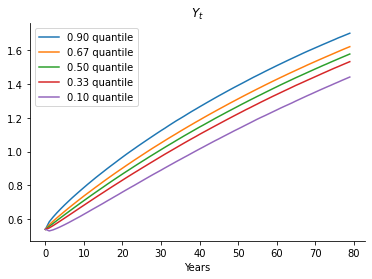

In [92]:
quantile_list = np.array([0.1, 0.33, 0.5, 0.67, 0.9])
for i, quantile in enumerate(quantile_list[::-1]):
    plt.plot(temp_quant[::-1][i], label="{:.2f} quantile".format(quantile))
plt.legend()
plt.title('$Y_t$')
plt.xlabel('Years')
# plt.savefig("temp.png", facecolor="w", edgecolor="w", bbox_inches="tight")